# Lab: Using Long Short-term Memory (LSTM) for predicting the next price in stock market

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
import datetime
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import Sequential
import time #helper libraries

Using TensorFlow backend.


In [2]:
# Install the package for running tensorboard on google colaboration
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print ("Running in Google COLAB : ", IN_COLAB)

if IN_COLAB:
    !pip install -q tf-nightly-2.0-preview
    # Load the TensorBoard notebook extension
    %tensorflow_version 2.x

Running in Google COLAB :  False


## Step 1: Dataset
### 1.1 - Load the Data

Here we are going to load the data. To do this we will be creating windows of size 50.  This means that we will be creating sequences of size 50 from the input data as our training examples.

We are also going to normalize the data within each window. This is because the long-term direction of the market will ultimately change (we hope it will get higher), and we want the magnitude to be apples-to-apples across windows.

In [3]:
# Run this cell if you need to get the data

!wget https://s3.amazonaws.com/elephantscale-public/data/stocks/sp500.csv



--2019-09-12 03:56:13--  https://s3.amazonaws.com/elephantscale-public/data/stocks/sp500.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48119 (47K) [text/csv]
Saving to: ‘sp500.csv’

sp500.csv           100%[===================>]  46.99K  --.-KB/s    in 0.08s   

2019-09-12 03:56:14 (609 KB/s) - ‘sp500.csv’ saved [48119/48119]



In [4]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

### 1.2 - Split the data

In [5]:
URL = 'sp500.csv'
X_train, y_train, X_test, y_test = load_data(URL, 50, True)

## Step 2: Build the model

Let's build the model.  We have two LSTM layers of size 50 and 100, respectively.

`return_sequences` means that we will pass the hidden state of the LSTM to the next layer. This is required if we are going to have a stacked series of LSTM layers, as we are doing in this case.

The final layer is a dense (fully-connected) layer, with an output of 1. This is because we are ultimately trying to predict the next value in the stock market (a regression problem). We use `linear` activation because this is a regression problem and we are trying to get a real number output.


In [6]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None,1),
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.011394262313842773


## Step 3: Setup Tensorboard

In [7]:
## This is fairly boiler plate code

import datetime
import os

app_name = 'lstm-stocks' # you can change this, if you like

tb_top_level_dir= '/tmp/tensorboard-logs'
tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
                                    datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
print ("Saving TB logs to : " , tensorboard_logs_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, histogram_freq=1)


Saving TB logs to :  /tmp/tensorboard-logs/lstm-stocks/2019-09-12--03-56-15


## Step 4: Train the Model

**=> TODO: Train the model for some number of epochs**

Don't run too long. Something less than 10 will finish quickly enough.


In [8]:
#Step 3 Train the model

model.fit(X_train,
          y_train,
          batch_size=512,
          epochs=10,
          validation_split=0.05,
          callbacks=[tensorboard_callback])

Train on 3523 samples, validate on 186 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
3523/3523 [==============================] - 6s 2ms/sample - loss: 0.0030 - val_loss: 9.8444e-04
Epoch 2/10
3523/3523 [==============================] - 1s 292us/sample - loss: 7.8091e-04 - val_loss: 5.4088e-04
Epoch 3/10
3523/3523 [==============================] - 1s 298us/sample - loss: 7.5570e-04 - val_loss: 5.7610e-04
Epoch 4/10
3523/3523 [==============================] - 1s 304us/sample - loss: 6.0490e-04 - val_loss: 3.6976e-04
Epoch 5/10
3523/3523 [==============================] - 1s 290us/sample - loss: 5.1579e-04 - val_loss: 4.4312e-04
Epoch 6/10
3523/3523 [==============================] - 1s 311us/sample - loss: 7.0390e-04 - val_loss: 3.3490e-04
Epoch 7/10
3523/3523 [==============================] - 1s 288us/sample - loss: 4.4356e-04 - val_loss: 3.4340e-04
Epoch 8/10
3523/3523 [==============================] - 1s 290us/sa

## Step 5: Predict

In [9]:
#Step 4 - Make Predictions  By steps of 50, before advancing another 50 steps

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*int(prediction_len)]
        predicted = []
        for j in range(int(prediction_len)):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


predictions = predict_sequences_multiple(model, X_test, 50, 50)


## Step 6: Plot the Predictions

See the results.  The results here show a series of validation, seeing if we had trained the model up to a point, and then predicting *from* that point.  

The results here won't be very accurate, so definitely don't **trade** on this model!  The goal is to see if the model got the general sense of the direction of the market **from that point**.   There will be some hits and misses here; that is to be expected.

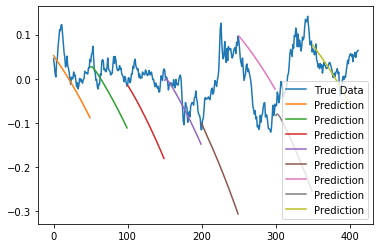

In [16]:
# Step 5 -- Plot predictions
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend(loc='best')
    plt.show()

plot_results_multiple(predictions, y_test, 50)

## Step 7: Run Tensorboard

In [11]:
if IN_COLAB:
    %tensorboard --logdir /tmp/tensorboard-logs

If you use this notebook local please click the following link:
    http://35.161.161.147:6006